Loads existing tfrecords that were generated by the SlideFlow package (and contain the image and slide name) and updates each tfrecord to include other metadata in addition to the existing ones.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import os
from pathlib import Path
from glob import glob

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def calc_records_in_tfr_folder(tfr_dir):
    """ Calc total number of examples (tiles) in all tfrecords. """
    count = 0
    for tfr_path in sorted(tfr_dir.glob('*.tfrec*')):
        count += sum(1 for _ in tf.data.TFRecordDataset(str(tfr_path)))
    print('Number of examples in all tfrecords in the folder:', count)

def calc_examples_in_tfrecord(tfr_path):
    """ Calc total number of examples (tiles) in all tfrecords. """
    count = sum(1 for _ in tf.data.TFRecordDataset(str(tfr_path)))
    print('Number of examples in the tfrecord:', count)

def show_img(img, title=None):
    """ Show a single image tile. """
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()
    
def show_images(img_list, ncols=4):
    """ Show  single image tile. """
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 20))
    
    for i, img_id in enumerate(np.random.randint(0, len(img_list), ncols)):
        ax[i].imshow(img_list[img_id]['image']); ax[i].axis("off"); ax[i].set_title(img_list[img_id]['slide'])

In [3]:
# Path to tfrecords
dpath = Path.cwd()/'project/tfrecords/PDX/300px_150um'
print(dpath)
tfr_files = sorted(dpath.glob('*.tfrec*'))
print('Number of tfrecords the folder:', len(tfr_files))
calc_records_in_tfr_folder(tfr_dir=dpath)
calc_examples_in_tfrecord(tfr_path=str(tfr_files[0]))

/vol/ml/apartin/projects/slideflow-proj/sf_pdx_proj/project/tfrecords/PDX/300px_150um
Number of tfrecords the folder: 10
Number of examples in all tfrecords in the folder: 3707
Number of examples in the tfrecord: 293


In [4]:
# Explore a single tfrecord
ftr_dataset = tf.data.TFRecordDataset(str(tfr_files[0]))
print('{}\n'.format(str(tfr_files[0])))

# Extract a single example (record) from the tfr dataset
rec_ex = next(ftr_dataset.__iter__())

# Get rid of the Tensor wrapping, leaving the byte string alone
# example = tf.train.Example()            # for sequence examples use tf.train.SequenceExample
# example.ParseFromString(rec_ex.numpy())
# print(str(example)[:500])               # the parsed result will be a human-readable protobuf

/vol/ml/apartin/projects/slideflow-proj/sf_pdx_proj/project/tfrecords/PDX/300px_150um/11107.tfrecords



In [5]:
# Load and explore a single example
# ---------------------------------
fea_spec = {
    'slide':     tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'image_raw': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None)
}

# Extract single example (record) from the tfr dataset
rec_ex = next(ftr_dataset.__iter__())
parsed_ex = tf.io.parse_single_example(rec_ex, features=fea_spec)

print(parsed_ex.keys())
print(parsed_ex['slide'])
print(parsed_ex['slide'].numpy())
print(parsed_ex['slide'].numpy().decode('utf-8'))

# Decode bytes string into numpy image data (single tile)
# decode_image() supports BMP, GIF, JPEG and PNG
print('\n{}'.format(parsed_ex['image_raw'].numpy()[:20]))
decoded_img = tf.io.decode_image(parsed_ex['image_raw'])

print(type(decoded_img))
print(type(decoded_img.numpy()))
print(decoded_img.numpy().shape)

dict_keys(['image_raw', 'slide'])
tf.Tensor(b'11107', shape=(), dtype=string)
b'11107'
11107

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
(300, 300, 3)


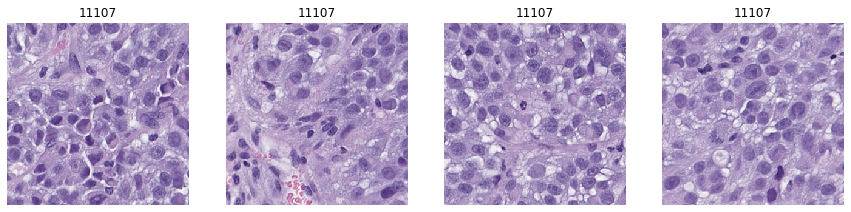

In [6]:
# Parse single tfrecord and store all image tiles in a list of dicts
# ------------------------------------------------------------------
fea_spec = {
    'slide':     tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'image_raw': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None)
}

img_list = []

ftr_dataset = tf.data.TFRecordDataset(str(tfr_files[0]))  # tfr_dataset
for i, ser_ex in enumerate(ftr_dataset):
    parsed_ex = tf.io.parse_single_example(ser_ex, features=fea_spec)
    item = {}
    item['slide'] = parsed_ex['slide'].numpy().decode('utf-8')
    item['image'] = tf.io.decode_image(parsed_ex['image_raw'])
    img_list.append(item)
    
show_images(img_list, ncols=4)

# Create tfrecord that contains image, rnaseq, and slide

In [7]:
# # -------------------------
# # Loading original tfrecord
# # -------------------------
# # Load a single tfrecord
# ftr_dataset = tf.data.TFRecordDataset(str(tfr_files[0]))
# print('{}\n'.format(str(tfr_files[0])))

# # Feature specs of the original tfrecord
# fea_spec_org = {
#     'slide':     tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
#     'image_raw': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None)
# }

# # Extract and parse a single example from tfrecord
# rec_ex = next(ftr_dataset.__iter__())  # get an example in the tfrecords
# parsed_ex = tf.io.parse_single_example(rec_ex, features=fea_spec_org)
# tf.print(parsed_ex.keys())

# # ---------------------
# # Creating new tfrecord
# # ---------------------
# tfr_fname = 'tmp_tfr.tfrecord'
# writer = tf.io.TFRecordWriter(tfr_fname)

# c_type = 'skin'
# dr_resp = 0.47
# rna = np.random.randn(7)

# tf_ex = tf.train.Example(features=tf.train.Features(
#     feature={
#         'slide':       tf.train.Feature(bytes_list=tf.train.BytesList(value=[parsed_ex['slide'].numpy()])),
#         'image_raw':   tf.train.Feature(bytes_list=tf.train.BytesList(value=[parsed_ex['image_raw'].numpy()])),
#         'cancer_type': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(c_type, 'utf-8')])),
#         'rna_raw':     tf.train.Feature(float_list=tf.train.FloatList(value=rna.flatten())),
#         'dr_resp':     tf.train.Feature(float_list=tf.train.FloatList(value=[dr_resp])), 
#     }
# ))

# writer.write(tf_ex.SerializeToString())
# writer.close()

# # ---------------------
# # Load the new tfrecord
# # ---------------------
# # Feature specs of the new tfrecord
# fea_spec_new = {
#     'slide':       tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
#     'image_raw':   tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
#     'cancer_type': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
#     'rna_raw':     tf.io.FixedLenFeature(shape=rna.flatten().shape, dtype=tf.float32, default_value=None),
#     'dr_resp':     tf.io.FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
# }

# ftr_dataset = tf.data.TFRecordDataset(tfr_fname)
# rec_ex = next(ftr_dataset.__iter__())  # get an example in the tfrecords
# parsed_ex = tf.io.parse_single_example(rec_ex, features=fea_spec_new)
# tf.print(parsed_ex.keys())

# print(parsed_ex['slide'])
# print(parsed_ex['cancer_type'])
# print(parsed_ex['dr_resp'])
# print(parsed_ex['rna_raw'])

# calc_examples_in_tfrecord(tfr_fname)

### Update entire tfrecord by adding new data attributes into each example

In [8]:
def update_tfrecord(tfr_path: str, outdir: str,
                    fea_spec_org: dict, # fea_spec_new: dict,
                    ctype: str, dr_resp: float, rna: np.array):
    """ Update the attributes of an exisiting tfrecord with new data attributes.
    Args:
        tfr_path: path to the tfrecord that needs to be modified
        outdir:   output dir to dump all the updated tfrecord
        fea_spec_org: original featue spec dict
        fea_spec_new: new featue spec dict
        c_type:   cancer type
        dr_resp:  drug response
        rna:      rna vector
    """
    # tfr writer
    tfr_fname = outdir/tfr_path.name
    ftr_dataset = tf.data.TFRecordDataset(str(tfr_fname))
    writer = tf.io.TFRecordWriter(str(tfr_fname))

    for i, rec_ex in enumerate(ftr_dataset):
        # if i%50 == 0: print(f'Tile {i}')

        parsed_ex = tf.io.parse_single_example(rec_ex, features=fea_spec_org)

        tf_ex = tf.train.Example(features=tf.train.Features(
            feature={
                'slide':     tf.train.Feature(bytes_list=tf.train.BytesList(value=[parsed_ex['slide'].numpy()])),
                'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[parsed_ex['image_raw'].numpy()])),
                'ctype':     tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(ctype, 'utf-8')])),
                'rna_raw':   tf.train.Feature(float_list=tf.train.FloatList(value=rna.flatten())),
                'dr_resp':   tf.train.Feature(float_list=tf.train.FloatList(value=[dr_resp])), 
            }
        ))

        writer.write(tf_ex.SerializeToString())

    writer.close()

In [9]:
tfr_out = Path.cwd()/'tfr_updated'
os.makedirs(tfr_out, exist_ok=True)

# Load a single tfrecord
# ftr_dataset = tf.data.TFRecordDataset(str(tfr_files[0]))
# print('{}\n'.format(str(tfr_files[0])))

# New data attributes
ctype = 'skin'
dr_resp = 0.47
rna = np.random.randn(7)

# original feature spec
fea_spec_org = {
    'slide':     tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'image_raw': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None)
}

# new feature spec
fea_spec_new = {
    'slide':     tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'image_raw': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'ctype':     tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
    'rna_raw':   tf.io.FixedLenFeature(shape=rna.flatten().shape, dtype=tf.float32, default_value=None),
    'dr_resp':   tf.io.FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
}

# Update
update_tfrecord(tfr_path=tfr_files[0],
                outdir=tfr_out,
                fea_spec_org=fea_spec_org,
                # fea_spec_new=fea_spec_new,
                ctype=ctype,
                dr_resp=dr_resp,
                rna=rna)

In [10]:
# Update the all tfrecords
for i, tfr_path in enumerate(tfr_files):
    update_tfrecord(tfr_path=tfr_path,
                    outdir=tfr_out,
                    fea_spec_org=fea_spec_org,
                    # fea_spec_new=fea_spec_new,
                    ctype=ctype,
                    dr_resp=dr_resp,
                    rna=rna)